In [ ]:
!unrar x "/content/w1.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/w1.rar


Would you like to replace the existing file w1/eight_WR.jpg
   578 bytes, modified on 2021-03-04 23:53
with a new one
   578 bytes, modified on 2021-03-04 23:53

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit q

Program aborted


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# read train 
train = pd.read_csv("/content/w1/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# read test 
test= pd.read_csv("/content/w1/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

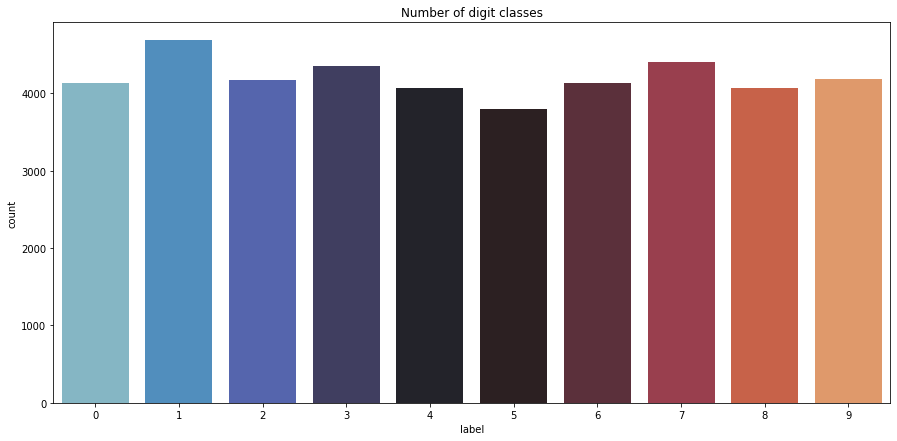

In [ ]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

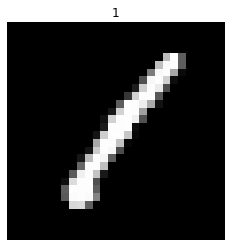

In [ ]:
# plot some samples
img = X_train.iloc[0].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()


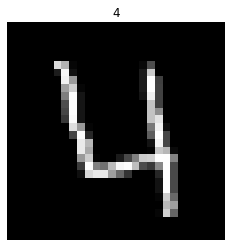

In [ ]:
# plot some samples
img = X_train.iloc[3].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [ ]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [ ]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


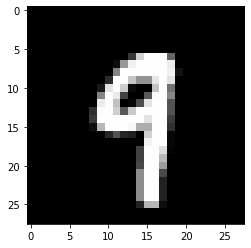

In [ ]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

In [ ]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)



In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 10  # for better result increase the epochs
batch_size = 250

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
151/151 [==============================] - 41s 59ms/step - loss: 1.5361 - accuracy: 0.4648 - val_loss: 0.1888 - val_accuracy: 0.9495
Epoch 2/10
151/151 [==============================] - 9s 56ms/step - loss: 0.4150 - accuracy: 0.8663 - val_loss: 0.1205 - val_accuracy: 0.9660
Epoch 3/10
151/151 [==============================] - 9s 57ms/step - loss: 0.3071 - accuracy: 0.9035 - val_loss: 0.1005 - val_accuracy: 0.9671
Epoch 4/10
151/151 [==============================] - 8s 56ms/step - loss: 0.2552 - accuracy: 0.9197 - val_loss: 0.0861 - val_accuracy: 0.9755
Epoch 5/10
151/151 [==============================] - 9s 56ms/step - loss: 0.2258 - accuracy: 0.9304 - val_loss: 0.0762 - val_accuracy: 0.9760
Epoch 6/10
151/151 [==============================] - 9s 57ms/step - loss: 0.1986 - accuracy: 0.9376 - val_loss: 0.0712 - val_accuracy: 0.9800
Epoch 7/10
151/151 [==============================] - 9s 56ms/step - loss: 0.1759 - accuracy: 0.9454 - val_loss: 0.0738 - val_accuracy: 0.977


kernal size interchanged, check for accuracy




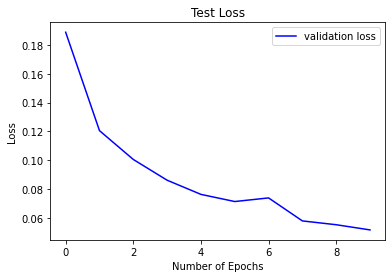

In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

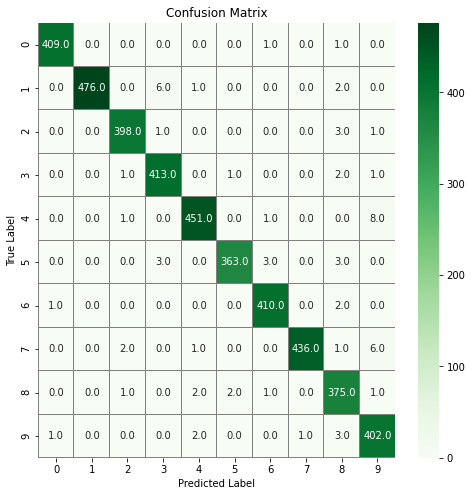

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('/content/w1/final_model.h5')

In [ ]:
import tensorflow as tf

model_loaded = tf.keras.models.load_model('/content/w1/final_model.h5')


In [ ]:
file_name = "/content/w1/seven_CR.png" 

Populating the interactive namespace from numpy and matplotlib


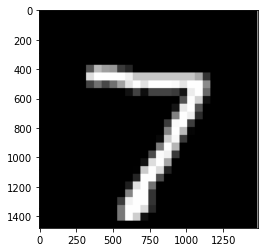

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(file_name)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
def load_image(file_name):
  img = load_img(file_name, grayscale=True, target_size=(28,28))
  img = img_to_array(img)
  img = img.reshape(1,28,28,1)
  img = img.astype('float32')
  img = img / 255.0
  return img

In [ ]:
from keras.preprocessing.image import load_img,img_to_array
from keras.models import load_model
def load_image(file_name):
  img = load_img(file_name,grayscale=True,target_size=(28,28))
  img = img_to_array(img)
  img = img.reshape(1,28,28,1)
  img = img.astype('float32')
  img = img / 255.0
  return img 

def run_example():
  img = load_image('/content/w1/six_CR.jpg')
  model = load_model('/content/w1/final_model.h5')
  digit = model.predict_classes(img)
  print(digit[0])

run_example()


6
